In [1]:
!pip install scikeras

In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dropout, Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor

import warnings
warnings.filterwarnings('ignore')

In [4]:
medi_cost = pd.read_csv('/kaggle/input/insurance/insurance.csv')

In [5]:
medi_cost.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
medi_cost.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [7]:
print(f"There are {medi_cost.shape[0]} rows, and {medi_cost.shape[1]} columns.")

There are 1338 rows, and 7 columns.


In [8]:
medi_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataatypes of all the columns is in correct formate so no need to do any changes in the dtype.

In [9]:
# Checking for null values 

medi_cost.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

No null values are present in the data.

In [10]:
medi_cost[medi_cost.duplicated]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


We got one duplicated entry in the datset.<br>
So now we will remove the duplicated entry from the data.

In [11]:
medi_cost.drop_duplicates(inplace = True)

The duplicated value have droped completely.

In [12]:
print(f'After removing duplicat values we got {medi_cost.shape[0]} rows, and {medi_cost.shape[1]} columns.')

After removing duplicat values we got 1337 rows, and 7 columns.


In [13]:
medi_cost.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


As we are dealing with the regression problem firstly we will look into the independent column i.e `charges` we will check its distributions and some others visualisation of targest columns.

In [14]:
medi_cost.charges.nunique()

1337

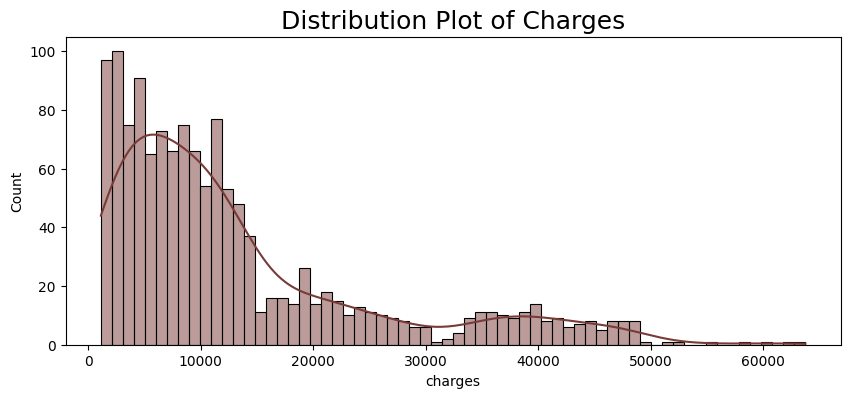

In [15]:
plt.figure(figsize = (10,4))
sns.histplot(x = medi_cost.charges, kde = True, bins = 64, color = "#783b37")
plt.title('Distribution Plot of Charges', fontsize = 18)
plt.show()

From above we can see that the maximum charges lies between 0 to 15,000.
The plot is not in gaussian distributes it is right skewed so we can use log normal to make our column into gaussian disribution.

<Figure size 1000x400 with 0 Axes>

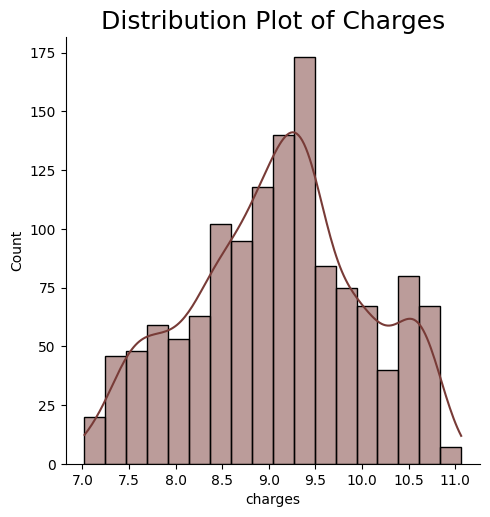

In [16]:
plt.figure(figsize = (10,4))
sns.displot(x = np.log(medi_cost.charges), kde = True, color = "#783b37")
plt.title('Distribution Plot of Charges', fontsize = 18)
plt.show()

### EDA

In [17]:
# Age
fig = px.histogram(medi_cost, x = 'age', marginal = 'box', nbins = 47, histnorm = 'density', 
                   title = "Distribution of Age")
fig.update_layout(bargap = 0.1)
fig.show()

In the `age` column we can see that the person whose age is of 18 and 19 is almost 70 as twise as rest of the age group.

In [18]:
# Sex vs cgarges
fig = px.histogram (medi_cost, x = "charges",marginal = 'box', color = 'sex',
                    color_discrete_sequence = ["red","violet"],
                    title = "Annual Medical charges with respect to Sex")

fig.update_layout (bargap = 0.1)
fig.show()

- For female and male the charges are almost the same i.e. \$9,377k.
- But we can also see that most of the insuranced policy holders is having less charges on their policy.

In [19]:
# bmi 

fig = px.histogram(medi_cost,x = 'bmi', marginal = 'box', color_discrete_sequence = ['#53c996'],
                  title = "Distribution of BMI")
fig.update_layout (bargap = 0.1)
fig.show()

BMI is having the Gaussian DIstribution as the value colse to the mean have higher chances og occuring.

In [20]:
# Bmi vs Charges

fig = px.scatter(medi_cost, x = 'bmi', y = 'charges', color = 'smoker',
                hover_data = ['sex'], opacity = 0.78,
                title = 'BMI vs. Charges')
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

In [21]:
# Smokers vs Charges
fig = px.histogram(medi_cost, x = 'charges', marginal = 'box', color = 'smoker', 
                   color_discrete_sequence = ['#32a807', '#0907a8'], 
                   title = 'Annual medical charges with respect to smokers and non smokers')

fig.update_layout(bargap = 0.1)
fig.show()

- For most customers, the annual medical charges are under \$14,000. But we can see that a small numbers of customers are have higher medical charges, possible due to some other factors like, accident, heat diseases, genetical deseases and much more. It follows the `power law` distribution.
- There are significant difference in medical expenses between smokers and non-smokers. The median of smoker 7,345 and for non smoker the median is $34,000.

In [22]:
# region vs charges

fig =  px.histogram(medi_cost, x = 'charges', marginal = 'box', color = 'region', 
                    color_discrete_sequence = ['#23eb94', '#afd9db', '#4aa9ed', '#d966ed'])
fig.update_layout (bargap = 0.1)
fig.show()

- On the basic of region there are not any changes in the charges, the median of all the 4 region with respect to charges is from $8,000 to 10,000.

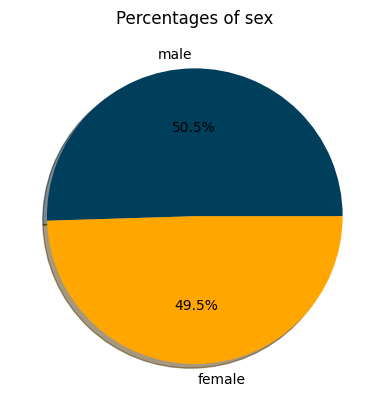

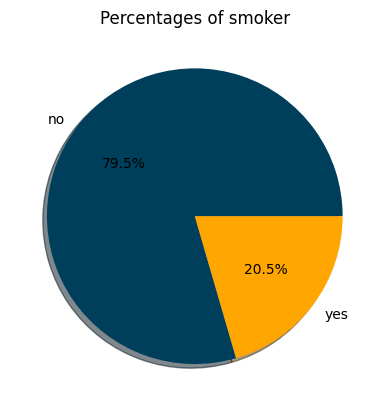

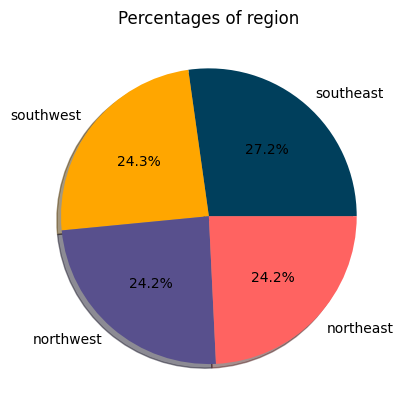

In [23]:
cat_features = medi_cost.select_dtypes(object)

for i in cat_features:
    counts = medi_cost[i].value_counts()
    plt.pie(counts, labels = counts.index, autopct = '%1.1f%%', shadow = True, 
            colors = ['#003f5c', '#ffa600','#58508d','#ff6361'],)
    plt.title(f"Percentages of {i}")
    plt.show()

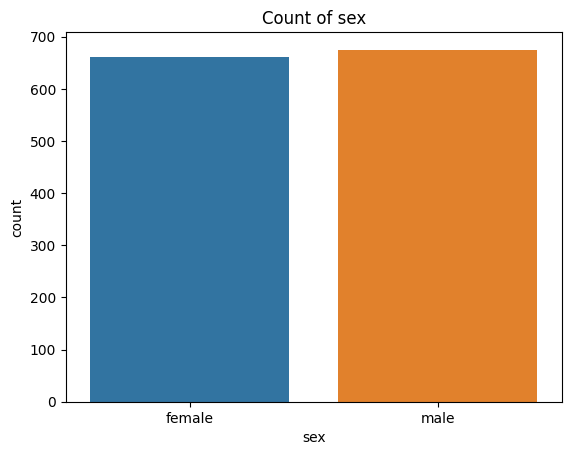

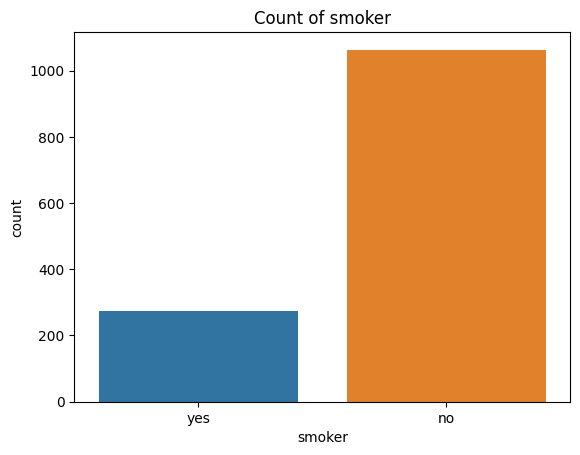

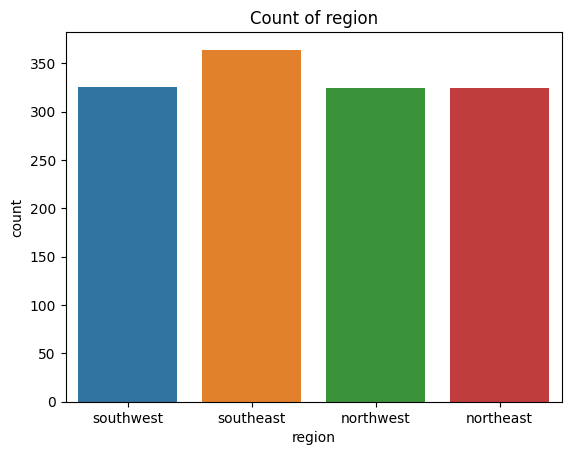

In [24]:
for i in cat_features :
    sns.countplot(x = medi_cost[i], data = medi_cost)
    plt.title(f"Count of {i}")
    plt.show()

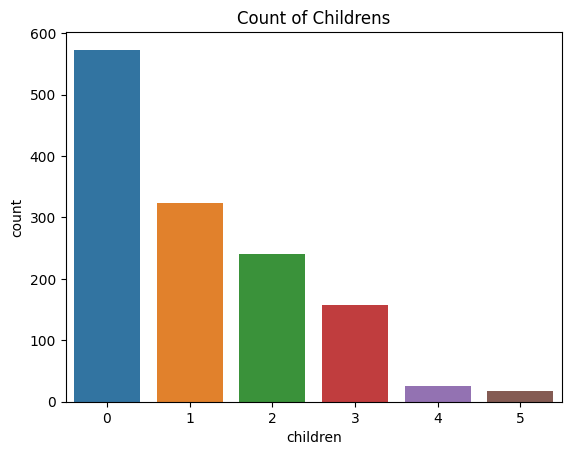

In [25]:
sns.countplot(medi_cost, x = medi_cost.children)
plt.title('Count of Childrens')
plt.show()

In [26]:
# Age and chagres
fig = px.scatter(medi_cost, x = 'age', y = 'charges',
                color = 'smoker', opacity = 0.8,
                hover_data = 'sex',
                title = 'Age vs. Charges')
fig.update_layout(bargap = 0.1)
fig.show()

From above observation we can say that as the age incereases the charges are also getting increases.<br>
Also we can see that age and charges are forming three cluster lines from that the most bottom cluster is on non smoker so we can say that non smoker is having low medical charges as compared to others.<br>
The second cluster contain a mix of smokers and non-smokers.<br>
And the final cluster contain only smokers and we can say that those who smoke are having high charges as compared to non-smokers.

In [27]:
# Age Vs, Charges (region) 

fig = px.scatter (medi_cost, x = "age", y = 'charges',
                 color = 'region', opacity = 0.6,
                 hover_data = ['sex'], title = 'Age Vs. Charges')

fig.update_layout (bargap =0.1)
fig.show()

In [28]:
fig = px.box(medi_cost, x = 'children', y = 'charges',
               title = "Children Vs. Charges")
fig.show()

In [29]:
# Sex vs. Charges

fig = px.box ( medi_cost, x = "sex", y = "charges",
            title = 'Sex Vs. Charges')
fig.show()

In [30]:
# Region vs. Charges
fig = px.box (medi_cost,x = 'region',y = 'charges',
             title = 'Region Vs. Charges')
fig.show()

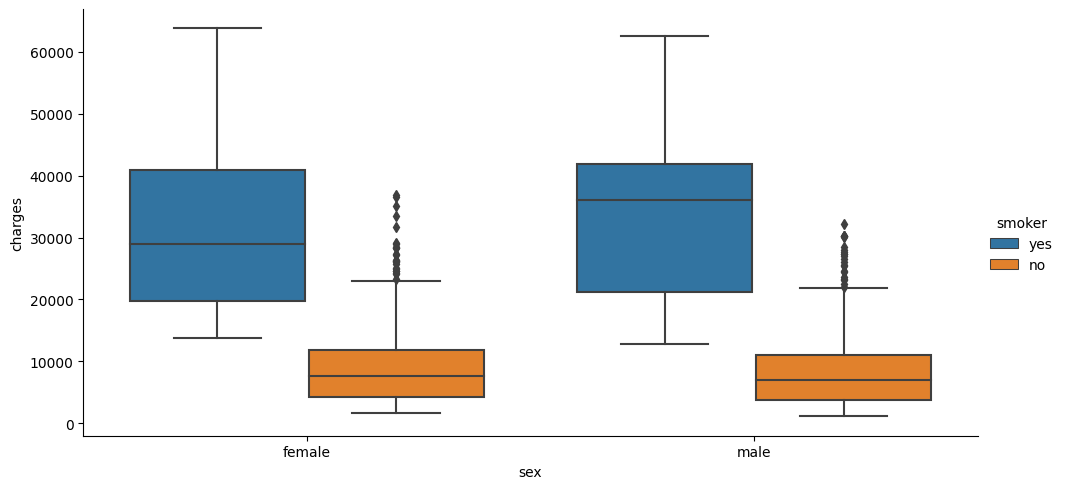

In [31]:
sns.catplot(medi_cost, x = 'sex', y = 'charges', hue = 'smoker', kind = 'box',
           aspect = 2, height = 5)

plt.show()

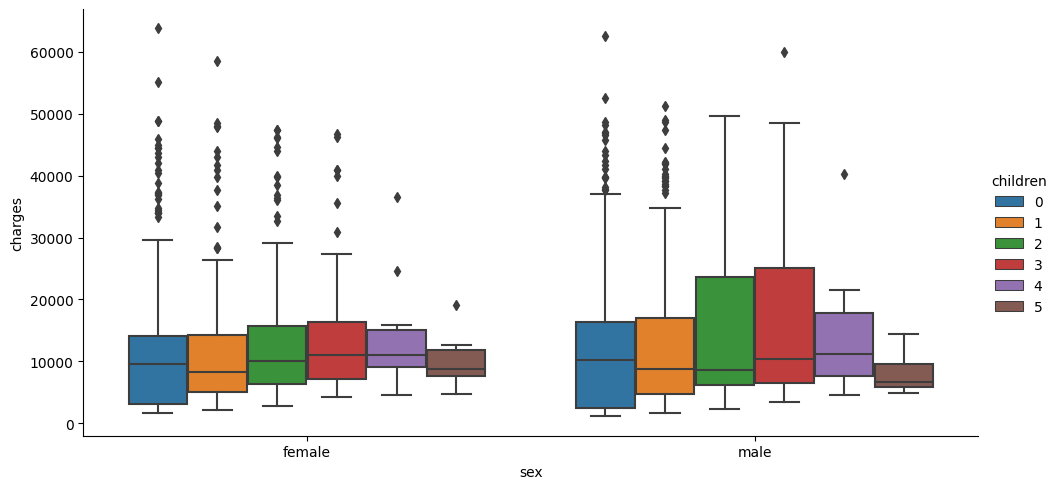

In [32]:
sns.catplot(x = 'sex', y = 'charges', hue = 'children', data = medi_cost, kind = 'box',
           aspect = 2, height = 5)
plt.show()

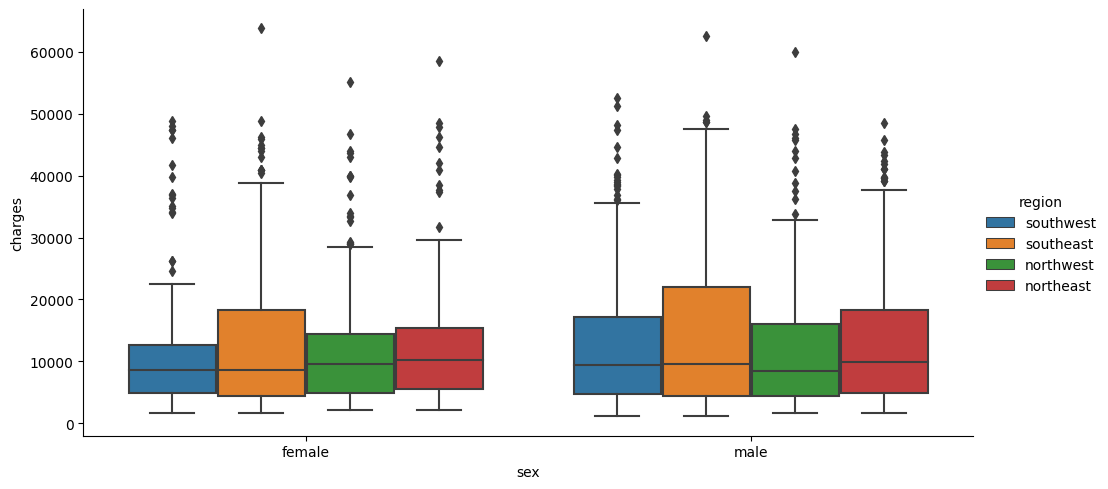

In [33]:
sns.catplot(x = 'sex', y = 'charges', hue = 'region', data = medi_cost, kind = 'box',
           aspect = 2, height = 5)
plt.show()

In [34]:
medi_child = medi_cost.groupby(['children'])['charges'].mean().reset_index()
medi_child

,children,charges
0,0,12384.695344
1,1,12731.171832
2,2,15073.563734
3,3,15355.318367
4,4,13850.656311
5,5,8786.035247


In [35]:
fig = px.bar(data_frame = medi_child, x = 'children', y = 'charges', color = 'charges')
fig.show()

In [36]:
fig = px.histogram(medi_cost, x = 'charges', nbins = 100, color = 'children', marginal = 'box', opacity = 0.8)
fig.update_layout (bargap = 0.1)
fig.show()

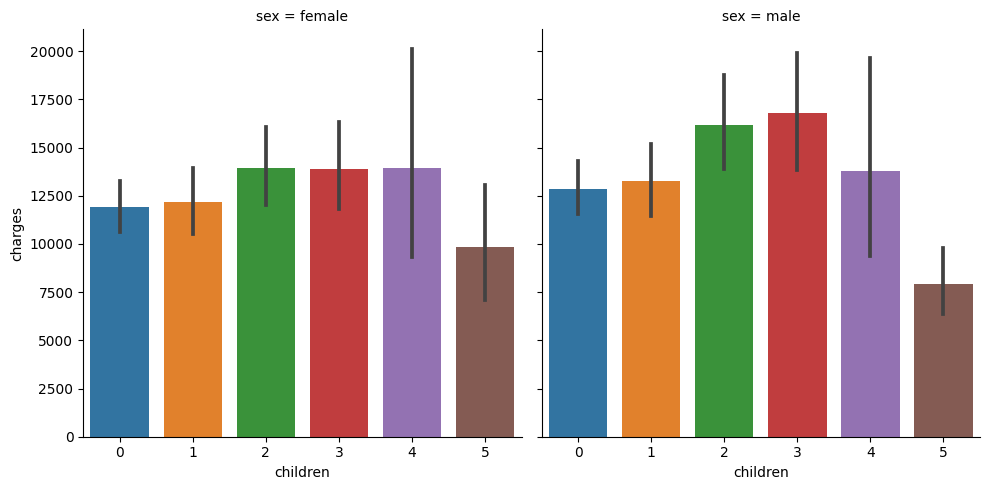

In [37]:
sns.catplot(medi_cost, x = 'children', y = 'charges', col = 'sex', kind = 'bar')
plt.show()

In [38]:
px.box(x = 'children', y = 'bmi', data_frame = medi_cost)

In [39]:
px.box(x = 'children', y = 'charges', color = 'smoker', data_frame = medi_cost)

In [40]:
px.box(x = 'children', y = 'charges', color = 'region', data_frame = medi_cost)

Patients having 2/3 children have the highest average charges may be because patients having 2/3 children are also smoker.<br>
Male patients having children have high charges than female patients.<br>
Highest patients having 2 children are from southwest region.

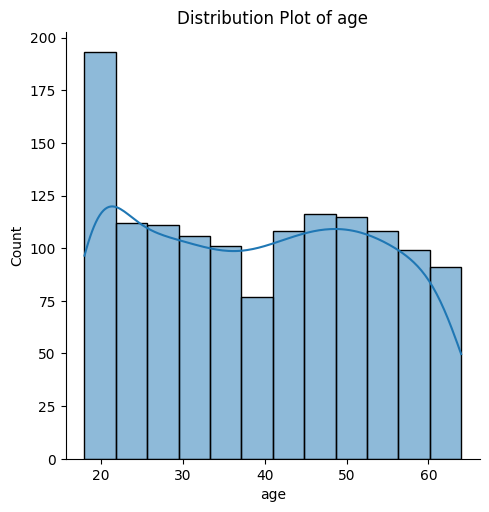

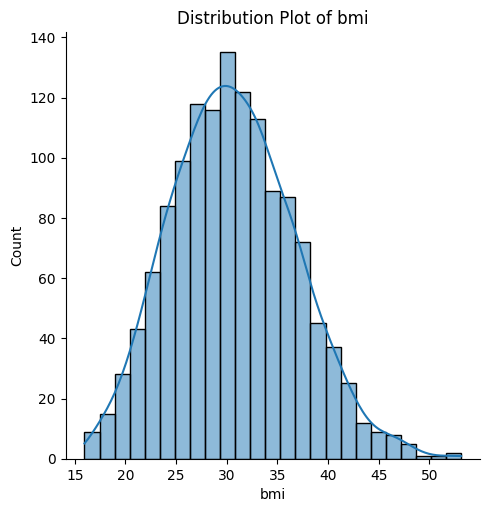

In [41]:
num_features = medi_cost[['age', 'bmi']]


for n in num_features:
    sns.displot(medi_cost[n], kde = True)
    plt.title(f"Distribution Plot of {n}")
    plt.show()

As we cann see that out `age` column in  uniformly distributed and `bmi` is Gaussian distributed.<br>
But we can convert the uniform distribution into Gaussion distribution using `mean and S.D` furthere we will perform this analysis.

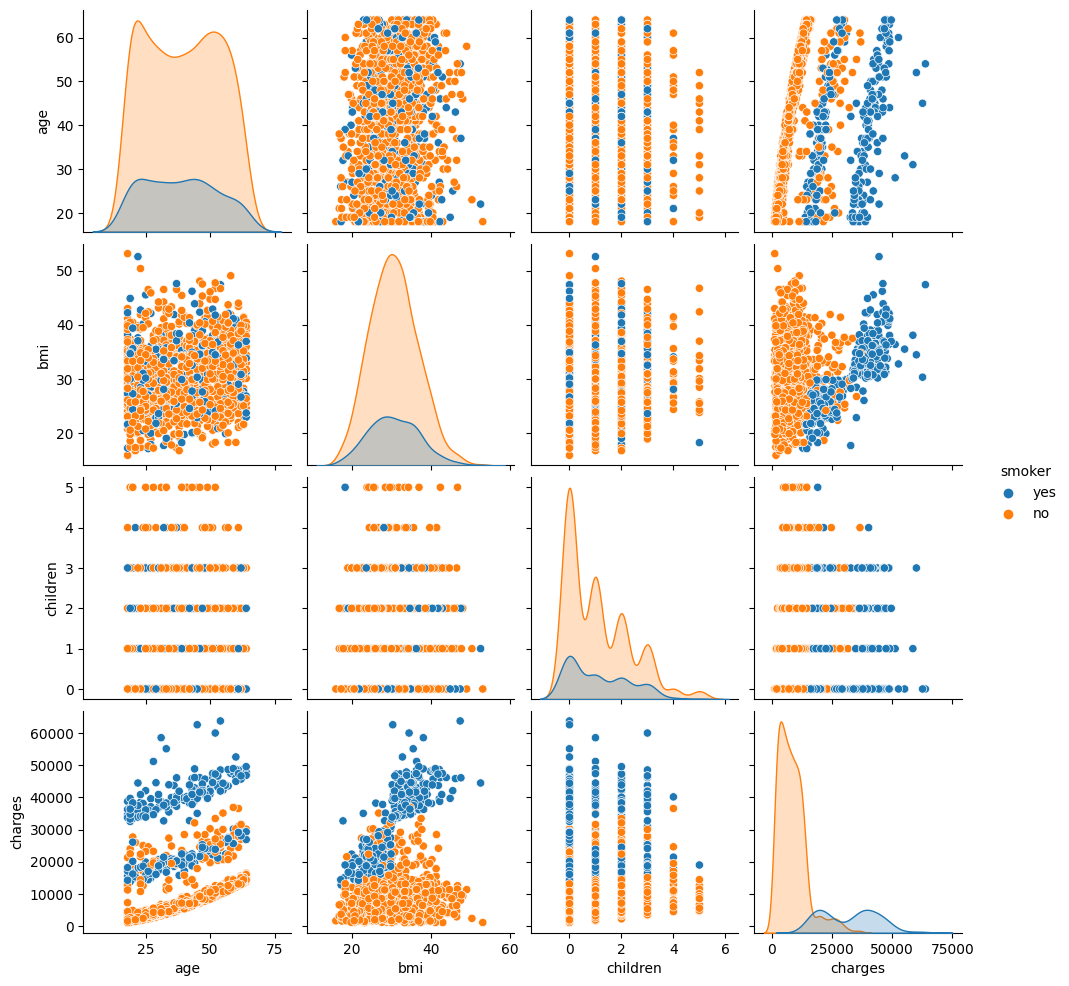

In [42]:
sns.pairplot(medi_cost, hue = 'smoker');

## Feature encoding

In [43]:
# col = ['Sex', 'smoker', 'region']


for i in medi_cost.columns:
    if medi_cost[i].dtype == 'object':
        lab_enc = LabelEncoder()
        lab_enc.fit(list(medi_cost[i].values))
        medi_cost[i]= lab_enc.transform(medi_cost[i].values)
        
medi_cost.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


## Correlation

In [44]:
medi_cost.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.019814,0.109344,0.041536,-0.025587,0.001626,0.298308
sex,-0.019814,1.000000,0.046397,0.017848,0.076596,0.004936,0.058044
bmi,0.109344,0.046397,1.000000,0.012755,0.003746,0.157574,0.198401
children,0.041536,0.017848,0.012755,1.000000,0.007331,0.016258,0.067389
smoker,-0.025587,0.076596,0.003746,0.007331,1.000000,-0.002358,0.787234
region,0.001626,0.004936,0.157574,0.016258,-0.002358,1.000000,-0.006547
charges,0.298308,0.058044,0.198401,0.067389,0.787234,-0.006547,1.000000


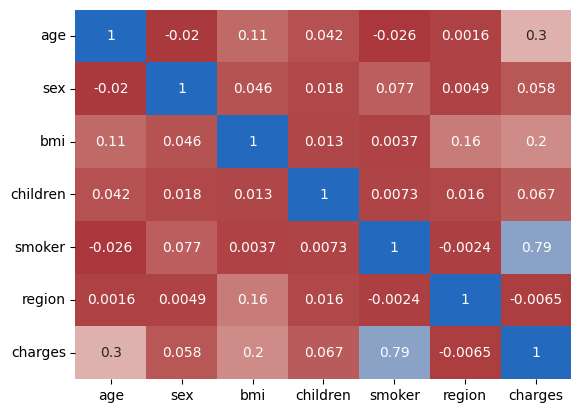

In [45]:
sns.heatmap(medi_cost.corr(), annot = True, cmap = "vlag_r", cbar = False)
plt.show()

From above observation we can see that Smokers are highely correlated with the charges.

In [46]:
# Creating the X and Y label

X = medi_cost.iloc[:,:-1]
y = medi_cost.iloc[:,-1]

In [47]:
# Splitting the data into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

In [48]:
# Scalling the data

scal = StandardScaler()
scal.fit(X_train)
X_train_scaled = scal.transform(X_train)
X_test_scaled = scal.transform(X_test)

In [49]:
X_train.shape

(1069, 6)

## Predecting Using ANN

In [50]:
model = Sequential()
model.add(Dense(512, input_dim = 6, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(.2))

model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
# model.compile
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               3584      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [51]:
history = model.fit(X_train_scaled, y_train, epochs = 400, validation_data=(X_test_scaled, y_test))


Epoch 1/400
34/34 [==============================] - 2s 12ms/step - loss: 311903136.0000 - mae: 13076.9668 - val_loss: 364284192.0000 - val_mae: 14009.9863
Epoch 2/400
34/34 [==============================] - 0s 6ms/step - loss: 277891840.0000 - mae: 11964.7129 - val_loss: 199947728.0000 - val_mae: 9052.5508
Epoch 3/400
34/34 [==============================] - 0s 6ms/step - loss: 73273688.0000 - mae: 6090.6270 - val_loss: 49312988.0000 - val_mae: 4720.9595
Epoch 4/400
34/34 [==============================] - 0s 6ms/step - loss: 47713752.0000 - mae: 4625.1182 - val_loss: 43122048.0000 - val_mae: 4361.7783
Epoch 5/400
34/34 [==============================] - 0s 7ms/step - loss: 41370752.0000 - mae: 4219.9976 - val_loss: 38526484.0000 - val_mae: 4040.7883
Epoch 6/400
34/34 [==============================] - 0s 7ms/step - loss: 40149676.0000 - mae: 3990.4143 - val_loss: 36099884.0000 - val_mae: 3860.3320
Epoch 7/400
34/34 [==============================] - 0s 7ms/step - loss: 39957252.0000

In [52]:
model.evaluate(X_test_scaled, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 25860238.0000 - mae: 2787.9661


[25860238.0, 2787.966064453125]

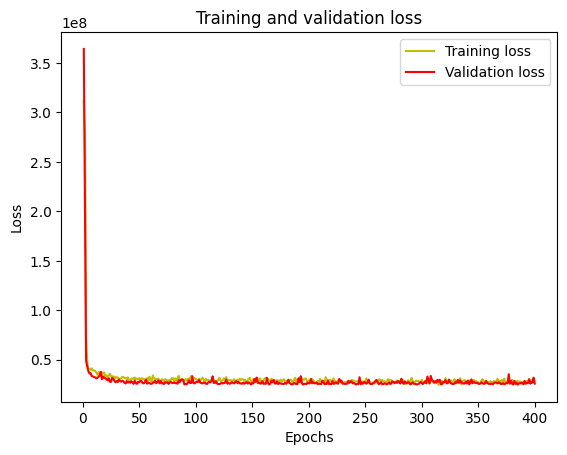

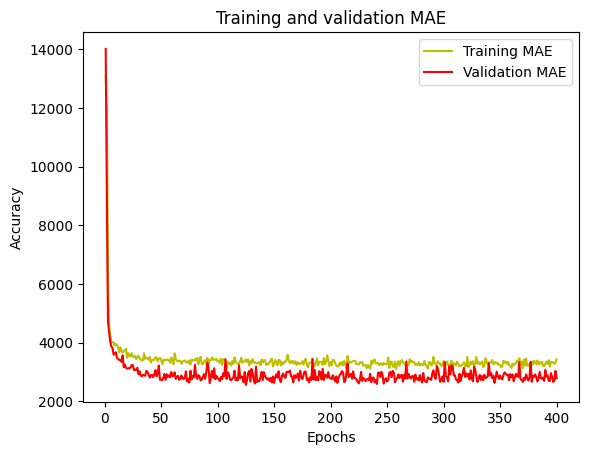

In [53]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['mae']
val_acc = history.history['val_mae']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
#Predict on test data
predictions = model.predict(X_test_scaled[:5])


print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5])

1/1 [==============================] - 0s 112ms/step
Predicted values are:  [[ 2993.2603]
 [ 9881.643 ]
 [ 9790.332 ]
 [23477.424 ]
 [ 9981.74  ]]
Real values are:  1248     1633.9618
610      8547.6913
393      9290.1395
503     32548.3405
198      9644.2525
Name: charges, dtype: float64


In [55]:
pred_df = pd.DataFrame({"Actual_Charges": y_test[:5], "Predicted_Charges": predictions.tolist()})
pred_df

,Actual_Charges,Predicted_Charges
1248,1633.9618,[2993.26025390625]
610,8547.6913,[9881.642578125]
393,9290.1395,[9790.33203125]
503,32548.3405,[23477.423828125]
198,9644.2525,[9981.740234375]


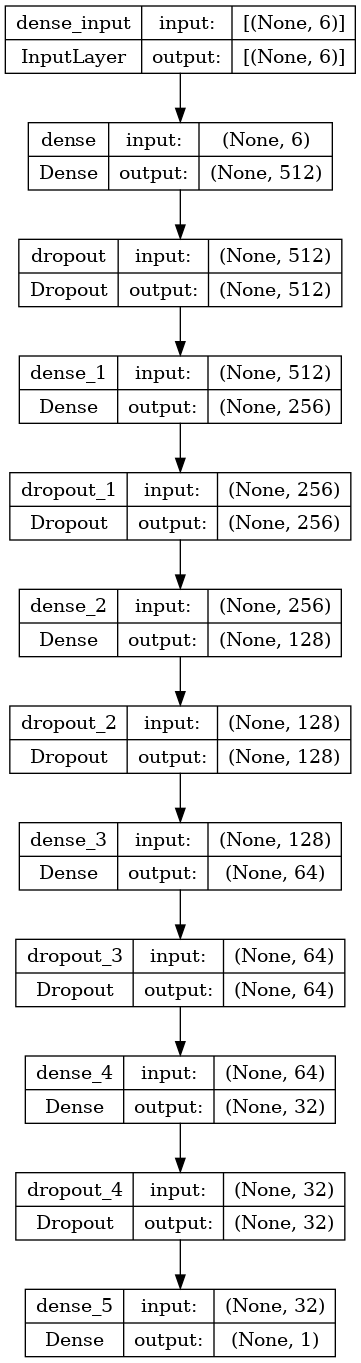

In [56]:


plot_model(model, show_shapes = True)

## Building a Linear Model 

In [57]:
def Evaluation(x_test, y_test, model) :
    y_pred = model.predict(x_test)    
    mse = mean_absolute_error(y_test, y_pred)
    msqe = mean_squared_error(y_test, y_pred)
    r2_scor = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("mean_absolute_error : ", mse)
    print("mean_squared_error  : ", msqe)
    print("root_mean_absolute_error", rmse)
    print("R2_score            : ", r2_scor)

### Linear regression

In [58]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

In [59]:
Evaluation(X_train_scaled, y_train, lr_model)

mean_absolute_error :  4020.32617197896
mean_squared_error  :  35403275.585444584
root_mean_absolute_error 5950.065174890489
R2_score            :  0.7487799749798774


In [60]:
Evaluation(X_test_scaled, y_test, lr_model)

mean_absolute_error :  4400.502490291577
mean_squared_error  :  41607776.51148495
root_mean_absolute_error 6450.409018929338
R2_score            :  0.7526726290709553


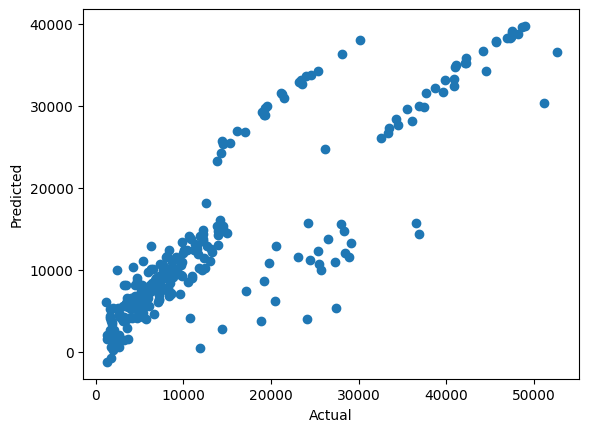

In [61]:
plt.scatter(y_test, y_pred_lr)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

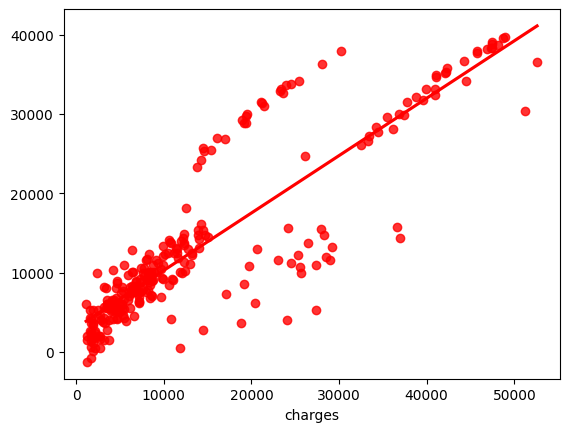

In [62]:
sns.regplot(x = y_test, y = y_pred_lr, ci = None, color = 'red');

## Ridge Regression

In [63]:
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train_scaled, y_train)
x_train_pred = ridge.predict(X_train_scaled)
x_test_pred = ridge.predict(X_test_scaled)

In [64]:
Evaluation(X_train_scaled, y_train, ridge)

mean_absolute_error :  4020.8261223668605
mean_squared_error  :  35403299.37695727
root_mean_absolute_error 5950.067174155034
R2_score            :  0.7487798061563911


In [65]:
Evaluation(X_test_scaled, y_test, ridge)

mean_absolute_error :  4401.3806936684405
mean_squared_error  :  41613069.25370484
root_mean_absolute_error 6450.819269961362
R2_score            :  0.7526411676440778


## Random Forest Regressor

In [66]:
Rfr = RandomForestRegressor(n_estimators = 100, criterion = 'squared_error',
                              random_state = 1,
                              n_jobs = -1)
Rfr.fit(X_train_scaled,y_train)
x_train_pred = Rfr.predict(X_train_scaled)
x_test_pred = Rfr.predict(X_test_scaled)

In [67]:
Evaluation(X_train_scaled, y_train, Rfr)

mean_absolute_error :  968.7810818205281
mean_squared_error  :  3354654.9567638724
root_mean_absolute_error 1831.5717176141022
R2_score            :  0.9761955217918146


In [68]:
Evaluation(X_test_scaled, y_test, Rfr)

mean_absolute_error :  2931.117996206777
mean_squared_error  :  27325815.892879065
root_mean_absolute_error 5227.4100559339195
R2_score            :  0.8375682920376348


### Gradient Boosting

In [69]:
gradient = GradientBoostingRegressor(max_depth = 4, n_estimators = 3, learning_rate = 0.8)

model = gradient.fit(X_train_scaled, y_train)

x_train_pred = model.predict(X_train_scaled)
x_test_pred = model.predict(X_test_scaled)

In [70]:
Evaluation(X_train_scaled, y_train, model)

mean_absolute_error :  2201.91612707674
mean_squared_error  :  15745939.242713984
root_mean_absolute_error 3968.1153262870253
R2_score            :  0.8882675349919811


In [71]:
Evaluation(X_test_scaled, y_test, model)

mean_absolute_error :  2904.180600465278
mean_squared_error  :  26990140.044859298
root_mean_absolute_error 5195.203561445816
R2_score            :  0.8395636359837885


### Decision Tree 

In [72]:
Dec_tree = DecisionTreeRegressor()
Dec_tree.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [73]:
Evaluation(X_train_scaled, y_train, Dec_tree)

mean_absolute_error :  29.60017904583723
mean_squared_error  :  244468.02917596183
root_mean_absolute_error 494.43708313188023
R2_score            :  0.9982652660413305


In [74]:
Evaluation(X_test_scaled, y_test, Dec_tree)

mean_absolute_error :  3469.383489552239
mean_squared_error  :  49441729.69583939
root_mean_absolute_error 7031.481330120943
R2_score            :  0.7061055878224816


### XGB Regressor 

In [75]:
Xgb = XGBRegressor()
Xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [76]:
Evaluation(X_train_scaled, y_train, Xgb)

mean_absolute_error :  461.9851094818153
mean_squared_error  :  754891.8135677928
root_mean_absolute_error 868.8451033226767
R2_score            :  0.9946433222023683


In [77]:
Evaluation(X_test_scaled, y_test, Xgb)

mean_absolute_error :  3141.3668575289325
mean_squared_error  :  30385889.714404523
root_mean_absolute_error 5512.339767685273
R2_score            :  0.819378422821293


By comparing all the mean absolute error we can say that our ANN model works far better than othere Regression model so we will deploy our model using ANN for furthere prediction and we will developing UI using ANN only.